In [463]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

In [2]:
.199e5


[1] 19900

# Synthesis methods

In [464]:
# load the full tables of bootstrapped results
obs_res <- read.csv("results-for-observations.csv", row.names = "X")
model_res <- read.csv("results-for-climate-models.csv", row.names = "X")

# select just the changes we're interested in
dI_obs <- obs_res[,grepl("dI.rel", colnames(obs_res))]
PR_obs <- obs_res[,grepl("PR", colnames(obs_res))]

dI_models_hist <- model_res[,grepl("attr_dI.rel", colnames(model_res))]
PR_models_hist <- model_res[,grepl("attr_PR", colnames(model_res))]

dI_models_proj <- model_res[,grepl("proj_dI.rel", colnames(model_res))]
PR_models_proj <- model_res[,grepl("proj_PR", colnames(model_res))]

# Fit model to observations

In [465]:
nsamp <- 1000  # set the number of samples to use in bootstrap (should be at least 1000)

# load covariate(s)
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))

# create dataframe with factual & counterfactual covariates (counterfactual could have multiple rows)
cov_now <- data.frame(gmst = gmst$gmst[gmst$year == 2023])
cov_hist <- cov_now - 1.2

In [466]:
for (fnm in list.files("ts", pattern = "obs", full.names = T)) {
    
    # specify filename to save results
    res_fnm <- paste0("res/res_", gsub(".dat", ".csv", gsub(".+/", "", fnm)))
    
    # only run if the results file doesn't already exist
    if(!file.exists(res_fnm)) {
        
        # load the time series file
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        
        # combine timeseries & GMSTs into a single dataframe
        df <- merge(ts, gmst)

        # fit the nonstationary model
        mdl <- fit_ns("norm", "fixeddisp", df, "pr", "gmst", lower = T)
        
        # bootstrap the model results
        res <- boot_ci(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = nsamp)
        
        # save output as .csv
        write.csv(res, res_fnm)
    }
}

## Compile obs results into a single file

In [467]:
# load all files & stack together
obs_res <- t(sapply(list.files("res", pattern = "obs", full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))
    
# relabel rows (default is to use full path to results file)
rownames(obs_res) <- gsub(".csv", "", sapply(strsplit(rownames(obs_res), "_"), "[", 5))
    
# save as single file
write.csv(obs_res, "results-for-observations.csv")

# Fit model to climate models

In [468]:
rp <- 10       # specify return period to evaluate
nsamp <- 1000  # set the number of samples to use in bootstrap (should be at least 1000)

for (fnm in list.files("ts", pattern = "CAM-22", full.names = T)) {
    
    # specify filename to save results
    res_fnm <- paste0("res/res_", gsub(".dat", ".csv", gsub(".+/", "", fnm)))
    
    # only run if the results file doesn't already exist
    if(!file.exists(res_fnm)) {
        
        # load the time series file
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        
        # load the GMSTs for this model (for CORDEX, GSATs from driving model)
        gmst_fnm <- list.files("ts", pattern = paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][4]), full.names = T)
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        
        # combine timeseries & GMSTs into a single dataframe
        df <- merge(ts, gmst)

        # specify the covariates to be used for the current, past and future climate
        cov_now <- df[df$year == 2023, "gmst", drop = F]
        row.names(cov_now) <- ""
        cov_hist <- cov_now - 1.2
        cov_fut <- cov_now + 0.8
        
        # fit the nonstationary model
        mdl <- fit_ns("norm", "fixeddisp", df, "pr", "gmst", lower = T)
        
        # bootstrap the model results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut,
                              y_now = 2023, y_start = 1979, y_fut = 2050, nsamp = nsamp)
        
        # save output as .csv
        write.csv(res, res_fnm)
    }
}

## Compile model results into a single file

In [469]:
# load all files & stack together
model_res <- do.call("rbind", sapply(list.files("res", pattern = "CAM-22", full.names = T), read.csv, row.names = "X", simplify = F))

# relabel rows (default is to use full path to results file)
rownames(model_res) <- gsub(".csv", "", gsub(".+CAM-22_", "", rownames(model_res)))

In [470]:
# save as single file
write.csv(model_res, "results-for-climate-models.csv")

# Synthesis

In [471]:
synth_abs_past <- synthesis(dI_obs, dI_models_hist, synth_type = "abs")
synth_rel_past <- synthesis(dI_obs, dI_models_hist, synth_type = "rel")
synth_PR_past <- synthesis(PR_obs, PR_models_hist, synth_type = "PR")

In [472]:
synth_abs_proj <- synthesis(NA, dI_models_proj, synth_type = "abs")
synth_rel_proj <- synthesis(NA, dI_models_proj, synth_type = "rel")
synth_PR_proj <- synthesis(NA, PR_models_proj, synth_type = "PR")

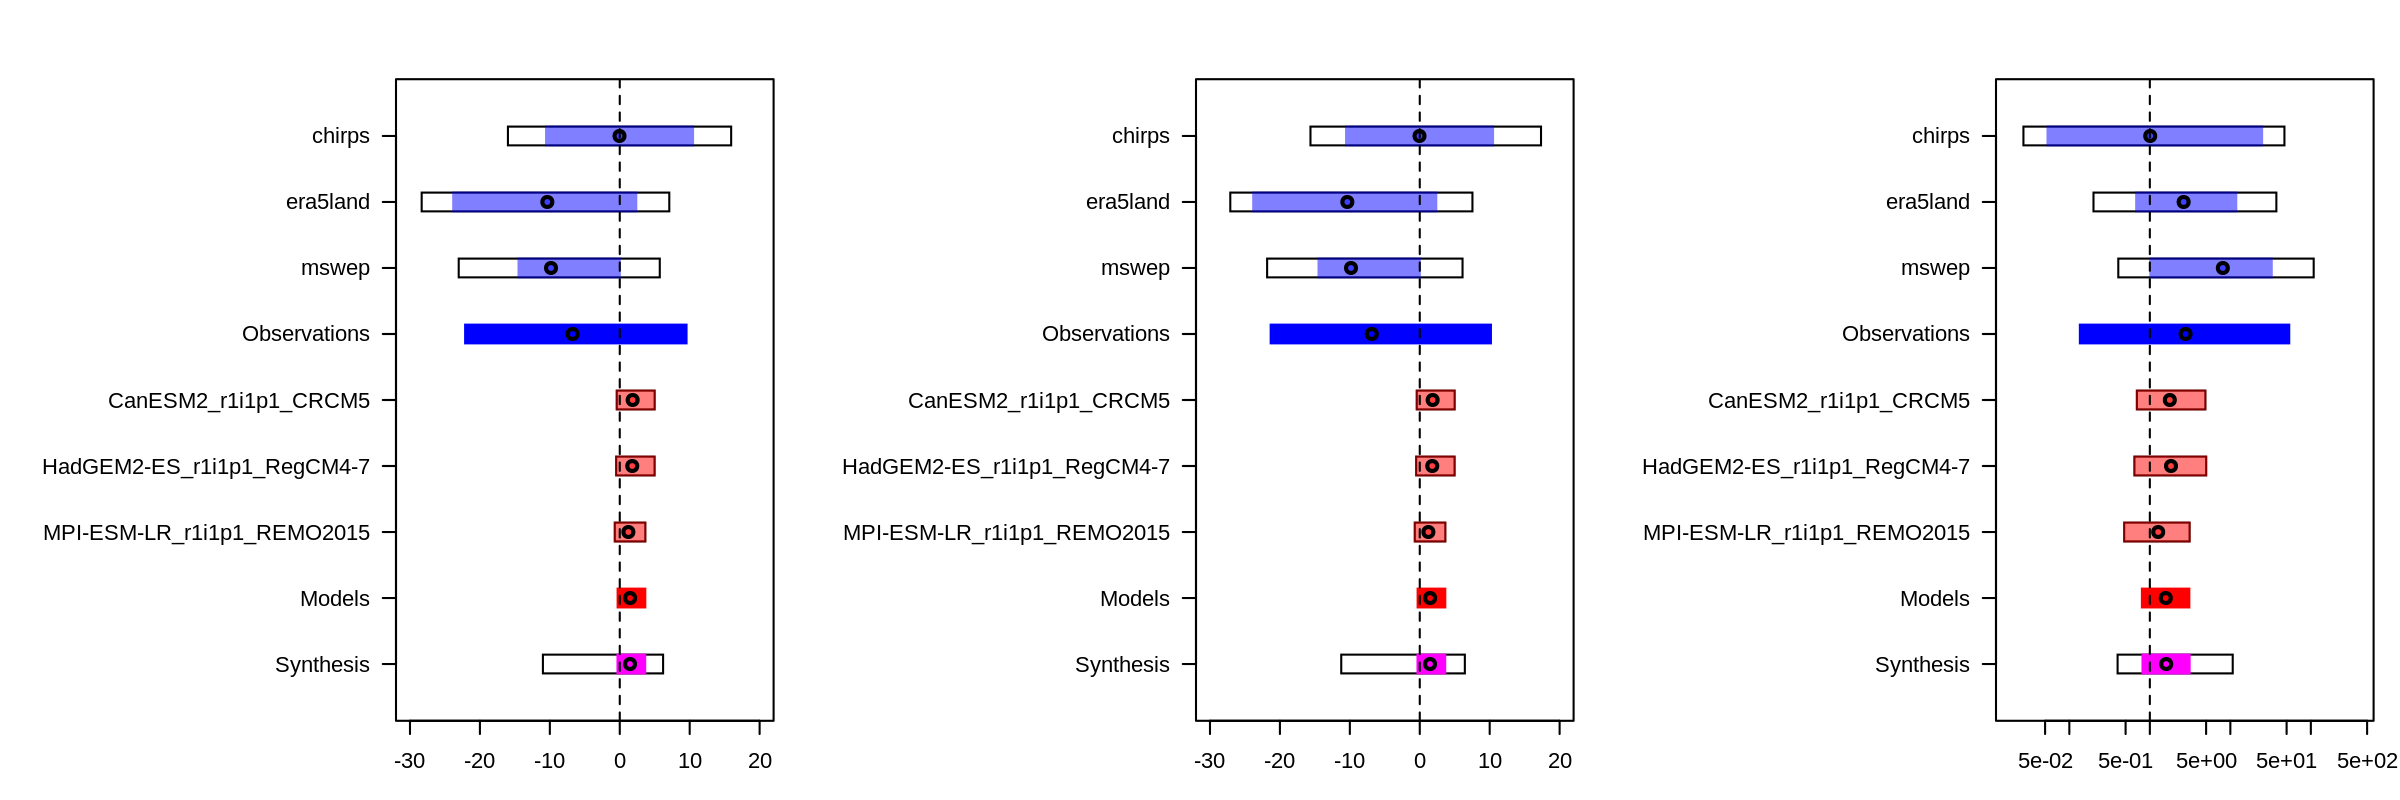

In [473]:
prep_window(c(1,3), mar = c(3,15,3,1))

plot_synthesis(synth_abs_past)
plot_synthesis(synth_rel_past)
plot_synthesis(synth_PR_past)

In [474]:
plot_synthesis <- function(synth, xlim, lwd = 10, xlab = "", main = "", add_space = F, log = NA) {

    gcols = c("obs" = adjustcolor("blue", 0.5),
              "obs_synth" = "blue",
              "models" = adjustcolor("red", 0.5),
              "model_synth" = "red",
              "synth" = "magenta")
    
    # determine whether to plot on log axes or not (assume not unless told otherwise)
    if(is.na(log)) {
        if(!is.null(synth$synth)) {
            if (synth$synth_type == "PR") {logaxs <- "x"} else {logaxs <- ""}
        } else {
            logaxs <- ""
        }
    } else {
        if(log) {logaxs <- "x"} else {logaxs <- ""}
    }
    
    if (logaxs == "x") {vline <- 1} else {vline <- 0}
    
    if (class(synth) == "list") synth <- synth$df
    
     if (missing(xlim)) {
        if(logaxs == "x") {
            xlim <- exp(range(pretty(log(as.numeric(unlist(synth[,c("lower", "upper", "l_wb", "u_wb")]))))))
        } else {
            xlim <- range(pretty(as.numeric(unlist(synth[,c("lower", "upper", "l_wb", "u_wb")]))))
        }
    }
    
    # relabel groups if needed (eg. is using results from climate explorer)
    if(is.numeric(synth$group)) synth$group <- names(gcols)[synth$group]
        
    nobs <- sum(synth$group == "obs")
    nmod <- sum(synth$group == "models")

    if(add_space & (nobs > 0)) {
        yy <- c(rev(0:nobs+nmod+4), rev(0:nmod+2), 0)
    } else {
        yy <- nrow(synth):1
    }
        
    plot(0, type = "n", xlim = xlim, ylim = range(yy) + c(-0.5,0.5), log = logaxs,
         yaxt = "n", ylab = "", xlab = xlab, main = main)

    gcols <- gcols[synth$group]

    segments(y0 = yy, x0 = synth$l_wb, x1 = synth$u_wb, lwd = lwd, col = "black", lend = 2)
    segments(y0 = yy, x0 = synth$l_wb, x1 = synth$u_wb, lwd = lwd-2, col = "white", lend = 2)
    segments(y0 = yy, x0 = synth$lower, x1 = synth$upper, lwd = lwd, col = gcols, lend = 2)
    points(synth$est, yy, pch = 21, bg = gcols, lwd = 2, cex = lwd/10)

    axis(2, at = yy, labels = synth$model, las = 1)    
    abline(v = vline, lty = 2)
}

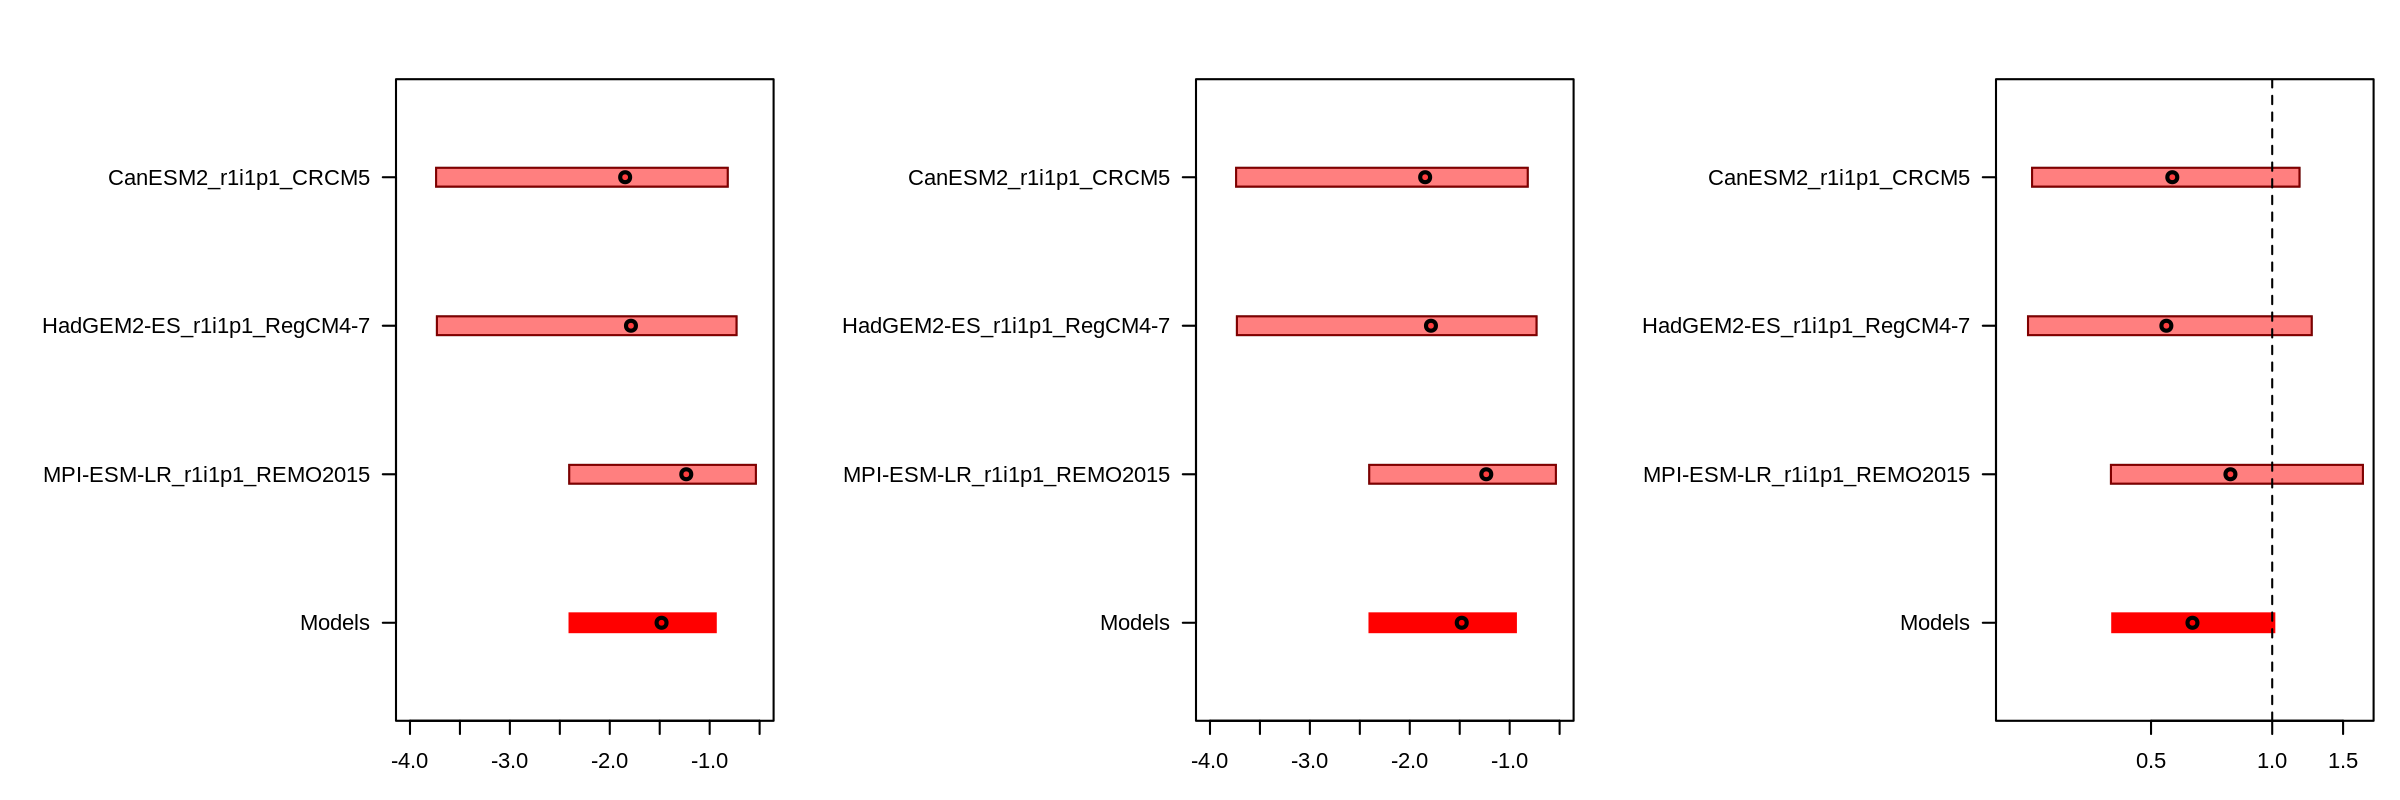

In [475]:
prep_window(c(1,3), mar = c(3,15,3,1))

plot_synthesis(synth_abs_proj)
plot_synthesis(synth_rel_proj)
plot_synthesis(synth_PR_proj)

# Check synthesis against climate explorer results

In [476]:
# check against climate explorer values
cx_abs_past <- read.table("cx_synth/cx-synth_dI-abs_hist.txt", col.names = c("y1", "y2", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"))
cx_rel_past <- read.table("cx_synth/cx-synth_dI-rel_hist.txt", col.names = c("y1", "y2", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"))
cx_PR_past <- read.table("cx_synth/cx-synth_PR_hist.txt", col.names = c("y1", "y2", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"))

cx_abs_proj <- read.table("cx_synth/cx-synth_dI-abs_proj.txt", col.names = c("y1", "y2", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"))
cx_rel_proj <- read.table("cx_synth/cx-synth_dI-rel_proj.txt", col.names = c("y1", "y2", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"))
cx_PR_proj <- read.table("cx_synth/cx-synth_PR_proj.txt", col.names = c("y1", "y2", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"))

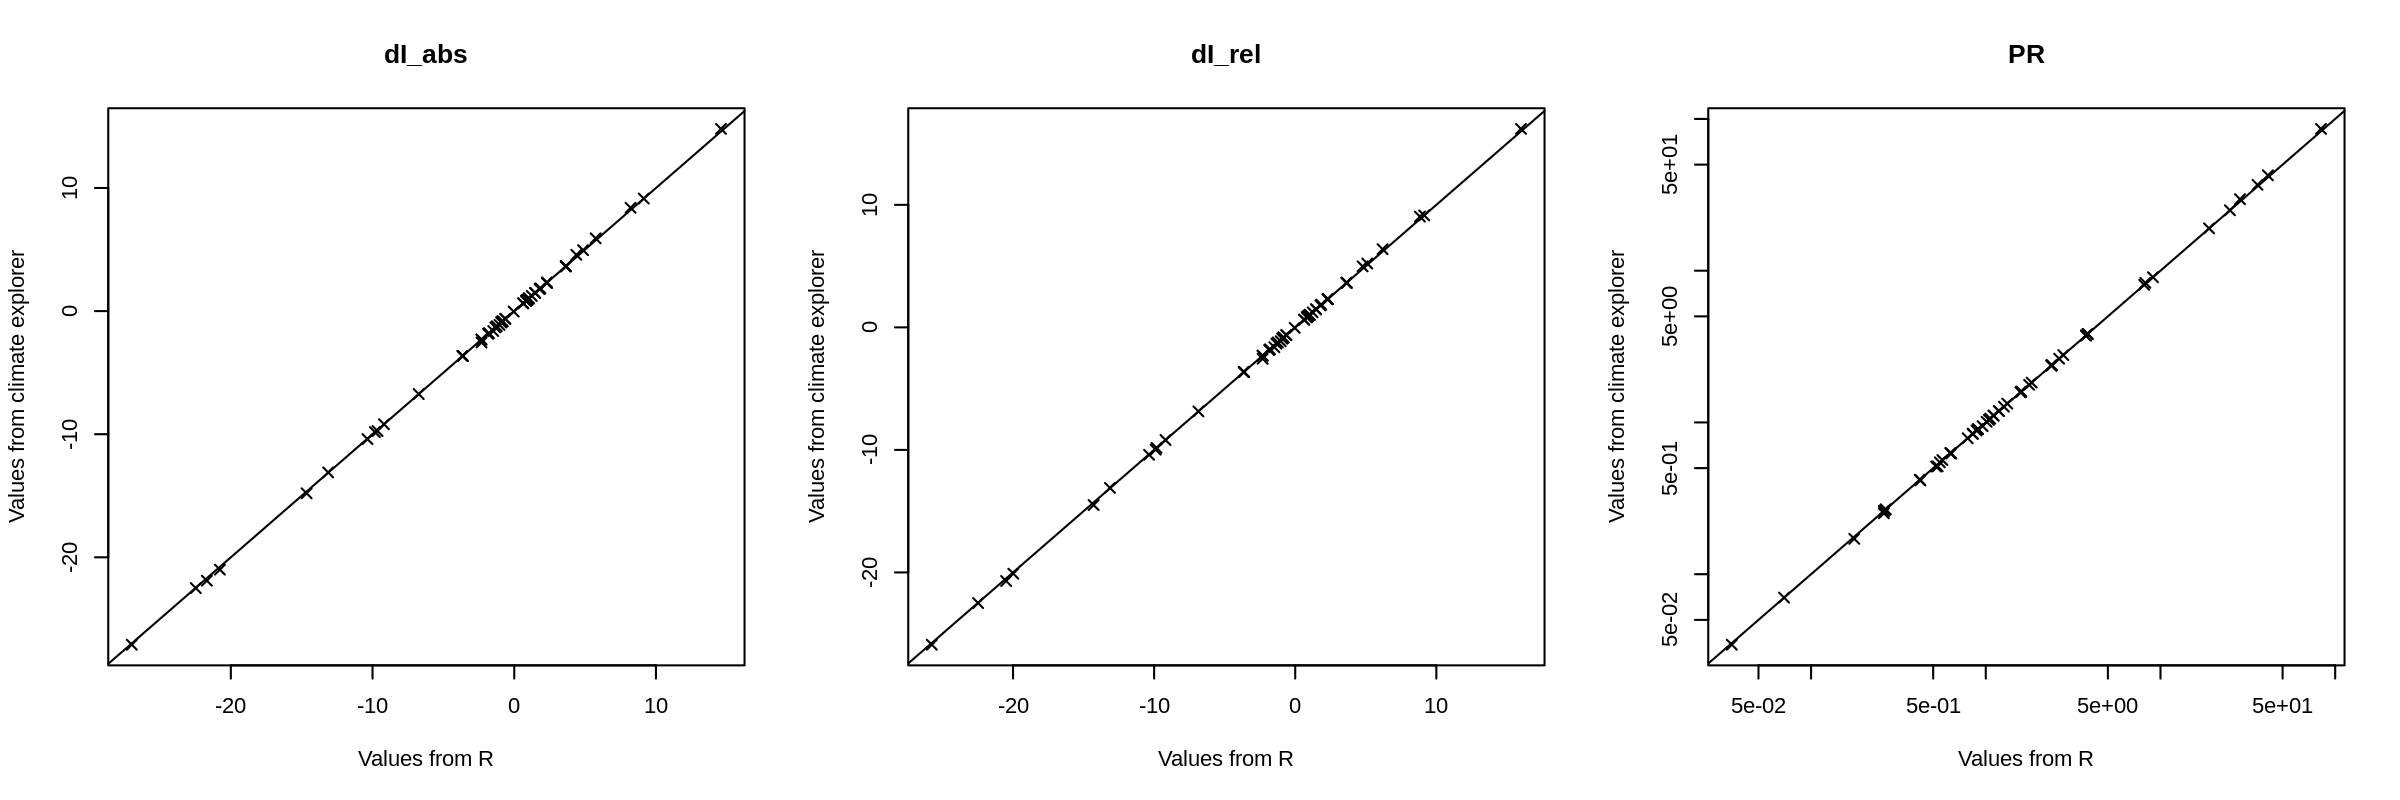

In [477]:
prep_window(c(1,3))

plot(unlist(synth_abs_past$df[,c("est", "lower", "upper", "l_wb", "u_wb")]), unlist(cx_abs_past[,c("est", "lower", "upper", "l_wb", "u_wb")]), pch = 4,
     xlab = "Values from R", ylab = "Values from climate explorer", main = "dI_abs")
points(unlist(synth_abs_proj$df[,c("est", "lower", "upper", "l_wb", "u_wb")]), unlist(cx_abs_proj[,c("est", "lower", "upper", "l_wb", "u_wb")]), pch = 4)
abline(0,1)

plot(unlist(synth_rel_past$df[,c("est", "lower", "upper", "l_wb", "u_wb")]), unlist(cx_rel_past[,c("est", "lower", "upper", "l_wb", "u_wb")]), pch = 4,
     xlab = "Values from R", ylab = "Values from climate explorer", main = "dI_rel")
points(unlist(synth_rel_proj$df[,c("est", "lower", "upper", "l_wb", "u_wb")]), unlist(cx_rel_proj[,c("est", "lower", "upper", "l_wb", "u_wb")]), pch = 4)
abline(0,1)

plot(unlist(synth_PR_past$df[,c("est", "lower", "upper", "l_wb", "u_wb")]), unlist(cx_PR_past[,c("est", "lower", "upper", "l_wb", "u_wb")]), pch = 4,
     xlab = "Values from R", ylab = "Values from climate explorer", main = "PR", log = "xy")
points(unlist(synth_PR_proj$df[,c("est", "lower", "upper", "l_wb", "u_wb")]), unlist(cx_PR_proj[,c("est", "lower", "upper", "l_wb", "u_wb")]), pch = 4)
abline(0,1)